BER với ước lượng LS và cân bằng ZF (SNR=20dB): 0.0693
BER không có ước lượng và cân bằng (SNR=20dB): 0.4454


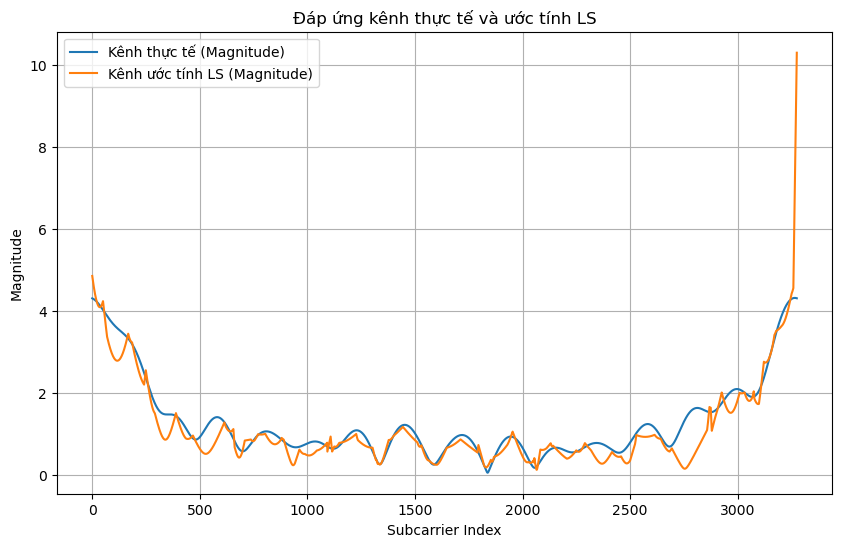

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from commpy.modulation import *

# Tham số OFDM
num_subcarriers = 3276
num_pilot_carriers = 100  # Ví dụ: số lượng subcarriers mang pilot
pilot_indices = np.sort(np.random.choice(np.arange(num_subcarriers), size=num_pilot_carriers, replace=False))

# Tạo chuỗi pilot đã truyền
qam_modem_pilot = QAMModem(4) # Ví dụ: QPSK cho pilot
# QPSK = 2 bits/symbol → generate raw bits, not symbol indices
pilot_bits = np.random.randint(0, 2, size=2 * num_pilot_carriers)
pilot_transmitted_symbols = qam_modem_pilot.modulate(pilot_bits)
DMRS = np.zeros(num_subcarriers, dtype=complex)
DMRS[pilot_indices] = pilot_transmitted_symbols

# Tạo kênh truyền ngẫu nhiên (ví dụ: FIR)
channel_response = np.exp(-np.linspace(0, 5, 20)) + 0.1j * np.random.randn(20)
fft_channel_response = np.fft.fft(channel_response, num_subcarriers)

# Tạo dữ liệu 16QAM
qam_modem_data = QAMModem(16)
num_data_symbols = num_subcarriers - len(pilot_indices)
data_indices = np.array([i for i in range(num_subcarriers) if i not in pilot_indices])
# Generate raw bits: 4 bits per symbol for 16-QAM
data_bits = np.random.randint(0, 2, size=4 * num_data_symbols)
transmitted_data_symbols = qam_modem_data.modulate(data_bits)
transmitted_signal_fft = np.zeros(num_subcarriers, dtype=complex)
transmitted_signal_fft[data_indices] = transmitted_data_symbols
transmitted_signal_fft[pilot_indices] = pilot_transmitted_symbols
transmitted_signal_ifft = np.fft.ifft(transmitted_signal_fft)

# Truyền qua kênh và thêm nhiễu
snr_db = 20
snr_linear = 10**(snr_db / 10)
power_signal = np.mean(np.abs(transmitted_signal_ifft)**2)
power_noise = power_signal / snr_linear
noise = np.sqrt(power_noise / 2) * (np.random.randn(len(transmitted_signal_ifft)) + 1j * np.random.randn(len(transmitted_signal_ifft)))
received_signal_time = np.convolve(transmitted_signal_ifft, channel_response, 'same') + noise
received_signal_fft = np.fft.fft(received_signal_time, num_subcarriers)

# Trích xuất pilot đã nhận
DMRS_receive = received_signal_fft[pilot_indices]

# Ước lượng kênh LS tại các vị trí pilot
H_LS_pilot = DMRS_receive / pilot_transmitted_symbols

# Ước lượng kênh trên tất cả các subcarriers bằng nội suy tuyến tính
H_LS = np.zeros(num_subcarriers, dtype=complex)
H_LS[pilot_indices] = H_LS_pilot
# Sắp xếp các chỉ số pilot để nội suy
sorted_pilot_indices = np.sort(pilot_indices)
sorted_H_LS_pilot = H_LS_pilot[np.argsort(pilot_indices)]
interp_real = interp1d(sorted_pilot_indices, np.real(sorted_H_LS_pilot), kind='linear', fill_value="extrapolate")
interp_imag = interp1d(sorted_pilot_indices, np.imag(sorted_H_LS_pilot), kind='linear', fill_value="extrapolate")
all_indices = np.arange(num_subcarriers)
H_LS = interp_real(all_indices) + 1j * interp_imag(all_indices)

# Cân bằng kênh sử dụng ZF
received_equalized_zf_fft = received_signal_fft / H_LS

# Giải điều chế dữ liệu sau cân bằng ZF
received_data_equalized_zf = received_equalized_zf_fft[data_indices]
demodulated_bits_zf = qam_modem_data.demodulate(received_data_equalized_zf, 'hard')
transmitted_data = np.random.randint(0, 16, size=num_data_symbols)
ber_zf = np.sum(demodulated_bits_zf != data_bits) / len(data_bits)
print(f"BER với ước lượng LS và cân bằng ZF (SNR={snr_db}dB): {ber_zf:.4f}")

# Giải điều chế dữ liệu không cân bằng
received_data_no_eq = received_signal_fft[data_indices]
demodulated_bits_no_eq = qam_modem_data.demodulate(received_data_no_eq, 'hard')
ber_no_eq = np.sum(demodulated_bits_no_eq != data_bits) / len(data_bits)
print(f"BER không có ước lượng và cân bằng (SNR={snr_db}dB): {ber_no_eq:.4f}")

# Hiển thị đáp ứng kênh ước tính
plt.figure(figsize=(10, 6))
plt.plot(np.abs(fft_channel_response), label='Kênh thực tế (Magnitude)')
plt.plot(np.abs(H_LS), label='Kênh ước tính LS (Magnitude)')
plt.xlabel('Subcarrier Index')
plt.ylabel('Magnitude')
plt.title('Đáp ứng kênh thực tế và ước tính LS')
plt.legend()
plt.grid(True)
plt.show()